# Predicting LTV

## Import Libraries

In [30]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.cluster import KMeans

## Create 2003 Training Data

Create dataframe for 2003.

In [2]:
data = pd.read_csv('sales_data_sample.csv',encoding='cp1252')

In [3]:
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'])

In [4]:
data = data.loc[(data['ORDERDATE'] > '01-01-2003') & (data['ORDERDATE'] <= '31-12-2003')]

In [5]:
data = data.drop(['ORDERNUMBER','QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','STATUS','QTR_ID',
                  'MSRP','PHONE','ADDRESSLINE1','ADDRESSLINE2','CITY','STATE','POSTALCODE',
                  'TERRITORY','CONTACTLASTNAME','CONTACTFIRSTNAME','MONTH_ID','YEAR_ID'],
                  axis=1)
last_purchase =((data.sort_values(by=['ORDERDATE'], 
                                 ascending=True)).set_index('ORDERDATE')).groupby('CUSTOMERNAME').idxmax()
last_purchase.columns = ['last_purchase_date']
last_purchase['last_purchase(days)'] = ((last_purchase['last_purchase_date'].max() 
                                   - last_purchase['last_purchase_date']).dt.days)
tot_orders = data.groupby(['CUSTOMERNAME']).count().sort_values(by=['SALES'], 
                                                                ascending=False).drop(['PRODUCTLINE',
                                                                                       'PRODUCTCODE',
                                                                                       'COUNTRY',
                                                                                       'DEALSIZE',
                                                                                       'ORDERDATE'],
                                                                                        axis=1)
tot_orders.columns = ['tot_orders']
tot_sales = data.groupby(['CUSTOMERNAME']).sum().sort_values(by=['SALES'],ascending=False)
tot_sales.columns = ['tot_sales']
ltv = (last_purchase.reset_index()[['CUSTOMERNAME',
                                    'last_purchase(days)']].merge(((tot_orders.reset_index()[['CUSTOMERNAME',
                                                                                        'tot_orders']])), 
                                                              how='inner', 
                                                              on='CUSTOMERNAME').merge(((tot_sales.reset_index()[['CUSTOMERNAME',
                                                                                                                  'tot_sales']])),
                                                                                         how='inner', 
                                                                                         on='CUSTOMERNAME')
      )
ltv=ltv[ltv.CUSTOMERNAME !='Euro Shopping Channel']
ltv=ltv[ltv.CUSTOMERNAME !='Mini Gifts Distributors Ltd.']

In [6]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [7]:
def apply_kmeans(lst):
    global temp_table
    for i in lst:
        kmeans.fit(temp_table[[str(i)]])
        temp_table[str(i) +'_cluster'] = kmeans.predict(temp_table[[str(i)]])
        temp_table = order_cluster(str(i) +'_cluster', str(i),temp_table,False)
        display(temp_table.groupby(str(i) +'_cluster')[str(i)].describe())

In [8]:
kmeans = KMeans(n_clusters=3)
temp_table = ltv
apply_kmeans(['last_purchase(days)','tot_orders','tot_sales'])

,count,mean,std,min,25%,50%,75%,max
last_purchase(days)_cluster,,,,,,,,
0,11.0,279.454545,29.176578,242.0,256.0,274.0,298.0,333.0
1,15.0,183.866667,31.461693,130.0,159.5,189.0,209.0,225.0
2,41.0,42.365854,29.240175,0.0,19.0,33.0,64.0,106.0


,count,mean,std,min,25%,50%,75%,max
tot_orders_cluster,,,,,,,,
0,8.0,31.000000,5.014265,25.0,27.75,30.5,32.5,41.0
1,25.0,15.400000,2.768875,12.0,13.00,15.0,17.0,22.0
2,34.0,7.441176,3.267760,2.0,4.50,8.5,10.0,11.0


,count,mean,std,min,25%,50%,75%,max
tot_sales_cluster,,,,,,,,
0,11.0,100563.331818,26939.728426,75064.60,83535.345,95678.88,101133.5650,165686.20
1,38.0,44491.383684,9109.869749,31363.18,37963.265,42291.13,50778.9800,63730.78
2,18.0,18041.922778,9433.300571,3348.46,8613.170,20359.72,26626.8575,28397.26


In [9]:
temp_table['tot_orders_cluster'] = temp_table['tot_orders_cluster'].replace({0:2, 2:0})
temp_table['tot_sales_cluster'] = temp_table['tot_sales_cluster'].replace({0:2, 2:0})

In [10]:
temp_table['ltv_2003'] = temp_table[
    'last_purchase(days)_cluster'] + temp_table[
    'tot_orders_cluster'] + temp_table[
    'tot_sales_cluster']

### Merge 2003 data with LTV labels.

In [11]:
final_data = pd.read_csv('final_data.csv',encoding='cp1252')

In [12]:
temp_table.head()

,CUSTOMERNAME,last_purchase(days),tot_orders,tot_sales,last_purchase(days)_cluster,tot_orders_cluster,tot_sales_cluster,ltv_2003
0,"AV Stores, Co.",266,16,51017.92,0,1,1,2
1,Baane Mini Imports,314,17,56176.66,0,1,1,2
2,Danish Wholesale Imports,301,15,58871.11,0,1,1,2
3,Alpha Cognac,158,15,55349.32,1,1,1,3
4,"Australian Collectors, Co.",224,17,60135.84,1,1,1,3


In [13]:
final_data.head()

,Unnamed: 0,CUSTOMERNAME,classic_cars_%,motorcycles_%,planes_%,ships_%,trains_%,trucks_buses_%,vintage_cars_%,tot_items,last_purchase(days),tot_orders,tot_sales,last_purchase(days)_cluster,tot_orders_cluster,tot_sales_cluster,ltv,priority
0,0,"AV Stores, Co.",0.37,0.00,0.00,0.14,0.06,0.00,0.43,51,195,51,157807.81,2,2,2,6,high
1,1,"Anna's Decorations, Ltd",0.52,0.13,0.00,0.00,0.00,0.20,0.15,46,131,46,153996.13,2,2,2,6,high
2,2,Danish Wholesale Imports,0.39,0.00,0.06,0.36,0.03,0.00,0.17,36,46,36,145041.60,2,2,2,6,high
3,3,L'ordine Souveniers,0.56,0.05,0.26,0.00,0.05,0.03,0.05,39,329,39,142601.33,2,2,2,6,high
4,4,La Rochelle Gifts,0.11,0.26,0.26,0.09,0.00,0.15,0.11,53,117,53,180124.90,2,2,2,6,high


There are two things that we can test; first, whether the ltv score that we assigned can be predicted by the 2003 data, and second, we can take see if the 2003 data can predict tot_sales per customer.

In [14]:
model_data = (temp_table.reset_index()[['CUSTOMERNAME',
                                        'last_purchase(days)_cluster',
                                        'tot_orders_cluster',
                                        'tot_sales_cluster',
                                        'ltv_2003']].merge(((final_data[['CUSTOMERNAME',
                                                                         'tot_sales',
                                                                         'ltv',
                                                                         'priority']])), 
                                                              how='inner', 
                                                              on='CUSTOMERNAME'))

In [15]:
model_data.head()

,CUSTOMERNAME,last_purchase(days)_cluster,tot_orders_cluster,tot_sales_cluster,ltv_2003,tot_sales,ltv,priority
0,"AV Stores, Co.",0,1,1,2,157807.81,6,high
1,Baane Mini Imports,0,1,1,2,116599.19,4,med
2,Danish Wholesale Imports,0,1,1,2,145041.60,6,high
3,Alpha Cognac,1,1,1,3,70488.44,1,low
4,"Australian Collectors, Co.",1,1,1,3,200995.41,5,high


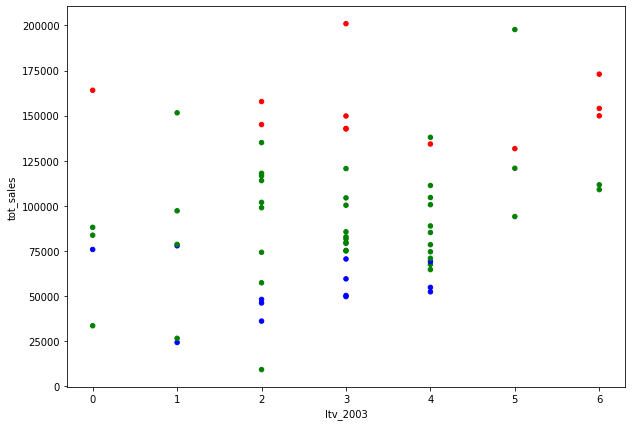

In [16]:
colors = {'high':'red', 'med':'green', 'low':'blue'}
model_data.plot(kind="scatter", x='ltv_2003', y='tot_sales',
    figsize=(10,7),
    c=model_data['priority'].apply(lambda x: colors[x]),
    )

There isn't an obvious correlation between ltv score in 2003 and lifetime sales.

## Train Machine Learning Model

Transform 'priority' classification into numeric.

In [17]:
customer_labels = final_data['priority'].astype('category').cat.categories.tolist()
replace_map_cust = {'priority' : {k: v for k,v in zip(customer_labels,list(range(1,len(customer_labels)+1)))}}
print(replace_map_cust)

{'priority': {'high': 1, 'low': 2, 'med': 3}}


In [18]:
final_data.replace(replace_map_cust, inplace=True)

In [19]:
final_data.dtypes

Unnamed: 0                       int64
CUSTOMERNAME                    object
classic_cars_%                 float64
motorcycles_%                  float64
planes_%                       float64
ships_%                        float64
trains_%                       float64
trucks_buses_%                 float64
vintage_cars_%                 float64
tot_items                        int64
last_purchase(days)              int64
tot_orders                       int64
tot_sales                      float64
last_purchase(days)_cluster      int64
tot_orders_cluster               int64
tot_sales_cluster                int64
ltv                              int64
priority                         int64
dtype: object

Drop CUSTOMERNAME.

In [20]:
final_data = final_data.drop(['CUSTOMERNAME','Unnamed: 0'],axis=1)

### Split training and test data

In [21]:
corr_matrix = final_data.corr()
corr_matrix['ltv'].sort_values(ascending=False)

ltv                            1.000000
tot_orders_cluster             0.883069
tot_sales_cluster              0.839886
tot_orders                     0.812367
tot_items                      0.812367
tot_sales                      0.808569
last_purchase(days)_cluster    0.471845
classic_cars_%                 0.154723
motorcycles_%                  0.010381
trains_%                      -0.008970
ships_%                       -0.015209
trucks_buses_%                -0.032548
planes_%                      -0.083267
vintage_cars_%                -0.093598
priority                      -0.315430
last_purchase(days)           -0.488215
Name: ltv, dtype: float64

In [27]:
X = final_data.drop(['ltv','tot_sales','classic_cars_%',
                    'motorcycles_%','planes_%','ships_%','trains_%',
                     'trucks_buses_%','vintage_cars_%','priority'],axis=1)
y = final_data['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=56)

### KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"4 KNN Accuracy: {round(knn.score(X_test, y_test)*100,2)}%")

4 KNN Accuracy: 66.67%


In [31]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'priority': {'high': 1, 'low': 2, 'med': 3}}
Confusion Matrix :
[[0 0 2]
 [0 2 1]
 [0 0 4]]
Accuracy Score : 0.6666666666666666
Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.67      0.80         3
           3       0.57      1.00      0.73         4

    accuracy                           0.67         9
   macro avg       0.52      0.56      0.51         9
weighted avg       0.59      0.67      0.59         9



### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
from sklearn import metrics
print(f"Random Forest Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100,2)}%")

Random Forest Accuracy: 100.0%


In [35]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'priority': {'high': 1, 'low': 2, 'med': 3}}
Confusion Matrix :
[[2 0 0]
 [0 3 0]
 [0 0 4]]
Accuracy Score : 1.0
Report : 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

